In [1]:
#Librerias básicas
#================================================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import duckdb
import glob

# Configuración para machine learning
# ================================================================================
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from pandas.core.frame import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import multiprocessing

import cv2

# Activar SQL en Python
# ================================================================================
con = duckdb.connect(database=':memory:')

2024-07-11 16:55:29.115558: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 16:55:29.531587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9241] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 16:55:29.531618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 16:55:29.595763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1516] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 16:55:29.724546: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 16:55:29.726502: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
##Estos urls son para Kaggle, entonces es necesario cambiarlos para local
#Curvas de luz
url_lcc = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/ClassificationExoplanets/Curvas_de_luz_God/"
#Caracteristicas de las estrellas
url    = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/ClassificationExoplanets/Exoplanet-detection-with-Neural-Network/"

In [13]:
#CallBack para detener entrenamiento
class MNIST_Callback(tf.keras.callbacks.Callback):
    
    # método dentro de la clase myCallback, heredada de la clase Callback de keras
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.95):
            print("\nSe alcanzó un 98.5% de precisión en la validación! Cancelando Entrenamiento...")
            self.model.stop_training = True
        elif(logs.get('accuracy')>0.95):
            rint("\nSe alcanzó un 98.5% de precisión en el entrenaminto! Cancelando Entrenamiento...")
            self.model.stop_training = True


# crea una instancia de clase
accu_callback = MNIST_Callback()

## Creación de datos de entrenamiento, validación y prueba

In [5]:
#Cargar caracteristicas de las estrellas 
Carac_Stars = pd.read_csv(url+"Carac_Stars.csv")
Carac_Stars

,Kepler_ID,Metalicidad,Clasificacion,incert_clas
0,10797460,0.136,CANDIDATE,1.000
1,10811496,-0.127,FALSE POSITIVE,0.000
2,10848459,-0.522,FALSE POSITIVE,0.000
3,10854555,0.081,CANDIDATE,1.000
4,10872983,-0.067,CANDIDATE,0.992
...,...,...,...,...
7677,10128825,-0.046,CANDIDATE,0.497
7678,10147276,-0.038,FALSE POSITIVE,0.021
7679,10156110,0.082,FALSE POSITIVE,0.000
7680,8460634,-0.556,FALSE POSITIVE,0.000


In [6]:
#Se sacan los nombres de las curvas de luz
arch = os.listdir(url_lcc) 
#Sacamos una lista con los KeplerID
Stars_list = [int(star[3:-4]) for star in arch]
#Ordenamos la lista con KeplerID en orden númerico 
Stars_list.sort()

s_flux  = []
s_err   = []
for Str in Stars_list:
    serie = pd.read_csv(url_lcc+'LC_'+Str+'.csv').set_index('time')
    s_flux.append(np.array(serie['flux'])[0:1284])
    s_err.append(np.array(serie['flux_err'])[0:1284])

In [7]:
Stars = pd.DataFrame()
Stars["ID"] = Stars_list
Stars

,ID
0,757450
1,1026032
2,1161345
3,1293031
4,1293046
...,...
2233,12644822
2234,12645761
2235,12690465
2236,12735740


In [9]:
#LEs asignamos una variable vinaria a cada estrella, 1 si es candidato 0 si no lo es
Clas_Stars = con.execute("""select S.ID, C.Metalicidad, case when C.Clasificacion == 'CANDIDATE' then 1 
                                              else 0             
                                         end as ClasBin
                            from Carac_Stars C inner join Stars S on (S.ID = C.Kepler_ID)
                            order by S.ID""").df()
Clas_Stars

,ID,Metalicidad,ClasBin
0,10000162,0.062,1
1,10000941,0.075,1
2,10001368,-0.083,1
3,10002049,-0.148,1
4,10002266,-0.384,0
...,...,...,...
7677,9993683,-0.052,1
7678,9994381,-0.170,1
7679,9995402,0.140,1
7680,9995771,-0.025,1


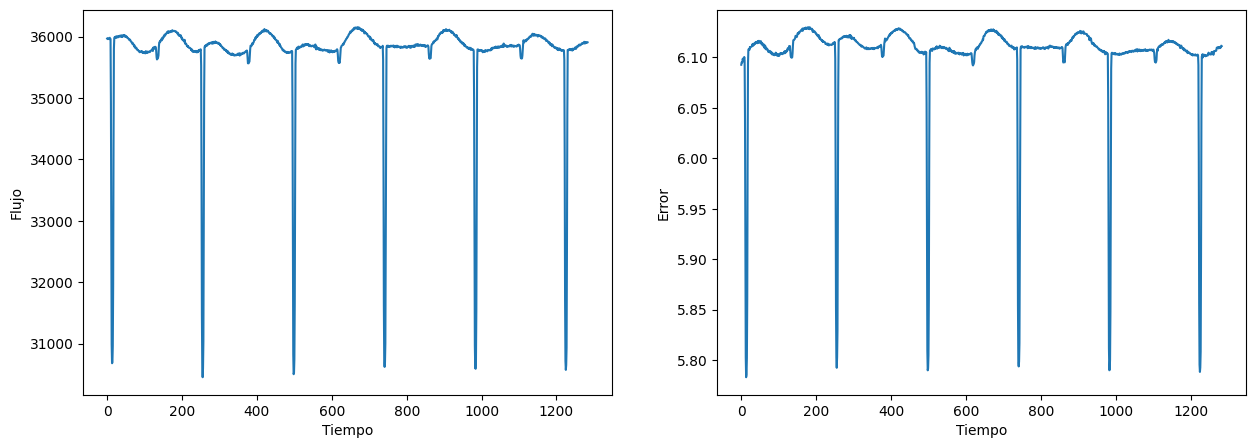

In [10]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(s_flux[198])
#plt.title(f'Curva de luz de la estrella {Stars[190]}') 
plt.ylabel('Flujo')
plt.xlabel('Tiempo')

plt.subplot(1,2,2)

plt.plot(s_err[198])
#plt.title(f'Error de la curva de luz de la estrella {Stars[190]}') 
plt.ylabel('Error')
plt.xlabel('Tiempo')

plt.show()

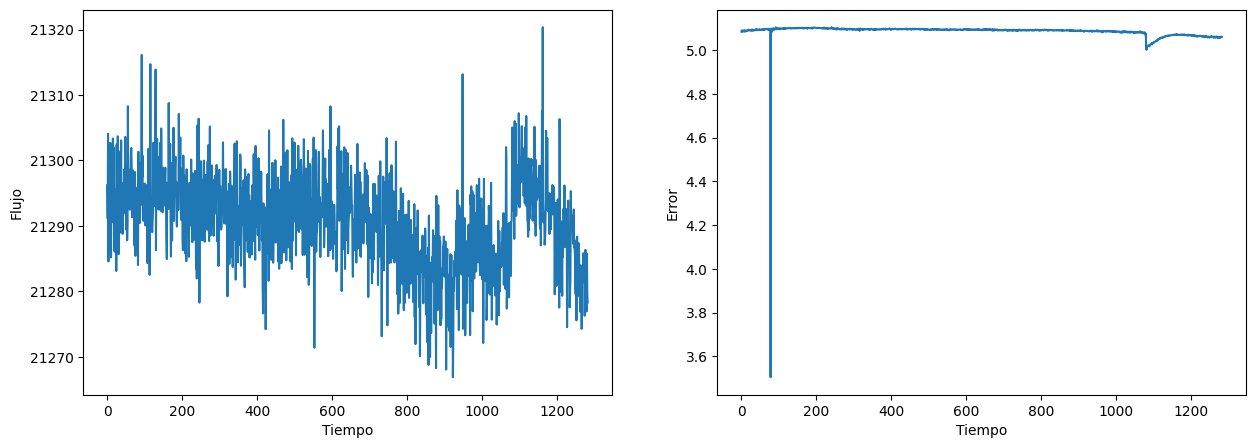

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(s_flux[6480])
#plt.title(f'Curva de luz de la estrella {Stars[6481]}') 
plt.ylabel('Flujo')
plt.xlabel('Tiempo')

plt.subplot(1,2,2)

plt.plot(s_err[6480])
#plt.title(f'Error de la curva de luz de la estrella {Stars[6481]}') 
plt.ylabel('Error')
plt.xlabel('Tiempo')

plt.show()

In [18]:
#Creación datos de validación 

#Se crean los datos de entrenamiento 
X_train, X_test, y_train, y_test = train_test_split(np.array(s_flux), 
                                                    np.array(Clas_Stars["ClasBin"]),
                                                    test_size=0.3, random_state=13)
#Se crean los datos de testeo y validación 
X_val,  X_test,  y_val,  y_test  = train_test_split(X_test, 
                                                    y_test,
                                                    test_size=0.333, random_state=13)

##Normalizamos las curvas de luz para realizar los entrenamientos 
#for i in range(len(X_train)):
#    mean_i = np.mean(X_train[i])
#    std_i  = np.std(X_train[i])
#    X_train[i] = (X_train[i] - mean_i)/std_i
#    
#for i in range(len(X_val)):
#    mean_i = np.mean(X_val[i])
#    std_i  = np.std(X_val[i])
#    X_val[i] = (X_val[i] - mean_i)/std_i

Tamaño de entrenamiento: (5377, 1284, 1) 
Tamaño de validacion: (1537, 1284, 1) 
Tamaño de prueba: (768, 1284, 1) 
Datos totales: 7682


In [ ]:
#Realizamos un reshape a nuestra conveniencia
X_train = X_train.reshape((len(X_train), 75000, 1))
X_test  = X_test.reshape((len(X_test), 75000, 1))
X_val   = X_val.reshape((len(X_val), 75000, 1))

print("Tamaño de entrenamiento:",X_train.shape,
      "\nTamaño de validacion:",X_val.shape,
      "\nTamaño de prueba:", X_test.shape,
      "\nDatos totales:",len(X_train)+len(X_val)+len(X_test))

In [17]:
len(y_train[y_train==1])

2274

In [18]:
len(y_train[y_train==0])

3103

## Red Convolucional (CNN)

### Explicación de cada función (Creditos a GPT)

#### conv1D
La función `Conv1D` en TensorFlow/Keras es una capa de convolución unidimensional que se utiliza comúnmente en modelos de procesamiento de secuencias, sus entradas principales son:

1. **filters**:
   - **Descripción**: Número de filtros o núcleos de convolución en la capa. Cada filtro aprende a detectar una característica diferente en la entrada.
   - **Dimensionalidad**: No cambia la longitud de la secuencia de entrada, pero añade una nueva dimensión que corresponde al número de filtros. Si la entrada tiene forma `(batch_size, length, channels)`, la salida tendrá forma `(batch_size, length, filters)`.

2. **kernel_size**:
   - **Descripción**: Tamaño del filtro de convolución. Define el número de pasos que se moverá el filtro sobre la secuencia de entrada. Es un entero positivo.
   - **Dimensionalidad**: Afecta a cómo se aplican los filtros sobre la secuencia, pero no cambia la dimensionalidad de la entrada por sí mismo.

3. **activation='leaky_relu'**:
   - **Descripción**: Función de activación que se aplicará al resultado de la convolución. La función `Leaky ReLU` es una versión modificada de la ReLU que permite pequeños valores negativos (generalmente, el valor negativo se multiplica por un pequeño factor como 0.01).
   - **Dimensionalidad**: No cambia la dimensionalidad de los datos, simplemente aplica una transformación punto a punto.

4. **padding="same"**:
   - **Descripción**: Tipo de padding que se aplicará a la entrada. "same" significa que se añadirán ceros a los bordes de la secuencia para asegurar que la salida tenga la misma longitud que la entrada.
   - **Dimensionalidad**: Asegura que la longitud de la secuencia de salida sea la misma que la de la entrada, manteniendo la dimensionalidad.

5. **input_shape**:
   - **Descripción**: Forma de la entrada esperada por la capa. Esto generalmente se especifica solo en la primera capa de un modelo. Por ejemplo, si la entrada es una secuencia de longitud 100 con 2 características por paso de tiempo, `input_shape` sería `(100, 2)`.
   - **Dimensionalidad**: Define la forma de la entrada a la red, pero no cambia la dimensionalidad de la entrada.

#### MaxPooling1D
La capa `MaxPooling1D` en TensorFlow/Keras se utiliza para reducir la dimensionalidad de la secuencia de entrada mediante la aplicación de una operación de "pooling" (agrupación) a lo largo de la dimensión temporal. la función tiene la siguente forma de actuar:

1. **pool_size**:
   - **Descripción**: Tamaño de la ventana sobre la que se aplica la operación de pooling. En este caso, `pool_size=2` significa que se considerarán 2 elementos adyacentes en la secuencia y se tomará el valor máximo de estos dos.
   - **Dimensionalidad**: La operación de max-pooling reduce la longitud de la secuencia. Si la secuencia de entrada tiene longitud `L`, la salida tendrá una longitud de `L / pool_size` (redondeando hacia abajo si `L` no es divisible por `pool_size`). Por lo tanto, si `L` es 100, después de aplicar `MaxPooling1D(pool_size=2)`, la longitud de la secuencia será 50.

#### Dropout 
La capa `Dropout` en TensorFlow/Keras se utiliza como técnica de regularización para reducir el sobreajuste en los modelos de redes neuronales. La idea es "apagar" (es decir, poner a cero) aleatoriamente un porcentaje de las unidades de la red durante el entrenamiento, lo que ayuda a la red a no depender demasiado de ninguna unidad en particular. Aquí te explico el parámetro que has especificado:

1. **rate (0.5)**:
   - **Descripción**: La fracción de unidades de entrada que se apagarán aleatoriamente durante el entrenamiento. En este caso, `0.5` significa que el 50% de las unidades de entrada serán puestas a cero en cada actualización de entrenamiento.
   - **Dimensionalidad**: No cambia la dimensionalidad de los datos. Simplemente, aplica una máscara binaria aleatoria a las unidades de entrada.

#### Flatten
La capa `Flatten` en TensorFlow/Keras se utiliza para convertir una entrada multidimensional en una forma unidimensional (o vector). Esto es especialmente útil cuando se desea conectar capas de convolución con capas densas, la funcionalidad de la función es:
- **Entrada**: Una entrada con cualquier número de dimensiones.
- **Operación**: Aplana todas las dimensiones excepto la dimensión del batch en una sola dimensión.
- **Salida**: Una salida unidimensional (vector) por cada muestra en el batch.

#### Dense
La capa `Dense` en TensorFlow/Keras es una capa completamente conectada (fully connected), que es una de las capas más comunes en las redes neuronales. Los parámetros de la función son:

1. **units (512)**:
   - **Descripción**: Número de unidades o neuronas en la capa. En este caso, hay 512 neuronas en esta capa.
   - **Dimensionalidad**: La salida de la capa tendrá una forma `(batch_size, 512)`, donde `batch_size` es el número de muestras en el batch de entrada.

2. **activation ('leaky_relu')**:
   - **Descripción**: Función de activación que se aplicará a la salida de cada neurona. En este caso, se usa `Leaky ReLU`, que es una versión modificada de ReLU. La función `Leaky ReLU` permite pequeños valores negativos, lo que puede ayudar a evitar el problema de unidades muertas que puede ocurrir con ReLU estándar.
   - **Dimensionalidad**: La función de activación no cambia la dimensionalidad de los datos, simplemente aplica una transformación punto a punto.

In [ ]:
from tensorflow.keras.layers import Conv1DTranspose, UpSampling1D, Reshape

In [60]:
### Se regula con Dropout
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='leaky_relu',padding="same", input_shape=(75000,1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(filters=128, kernel_size=5, activation='leaky_relu',padding="same"),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(filters=256, kernel_size=5, activation='leaky_relu',padding="same"),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(filters=512, kernel_size=5, activation='leaky_relu',padding="same"),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='leaky_relu'),
    Dropout(0.3),
    Dense(256, activation='leaky_relu'),
    Dropout(0.3),
    Dense(128, activation = 'leaky_relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

El parámetro `kernel_regularizer` en una capa densa (o cualquier otra capa que tenga pesos entrenables) se utiliza para aplicar regularización a los pesos de la capa. La regularización es una técnica para evitar el sobreajuste en los modelos de aprendizaje automático al penalizar grandes pesos, lo que generalmente conduce a un modelo más simple y generalizable. El parámetro `kernel_regularizer=l2(0.01)` funciona de la siguiente manera:

#### `kernel_regularizer=l2(0.01)`

1. **`kernel_regularizer`**:
   - **Descripción**: Especifica la función de regularización que se aplicará a los pesos de la capa (`kernel` se refiere a los pesos de la capa en Keras).
   - **Funcionalidad**: Keras ofrece varias funciones de regularización, y una de las más comunes es la regularización L2.

2. **`l2(0.01)`**:
   - **Descripción**: Aplica regularización L2 a los pesos de la capa. La regularización L2 agrega una penalización proporcional al cuadrado de la magnitud de los pesos a la función de pérdida del modelo.
   - **Parámetro (`0.01`)**: Es el factor de regularización, que controla la fuerza de la penalización. En este caso, `0.01` es el coeficiente que multiplica la suma de los cuadrados de los pesos.

#### Cómo Funciona la Regularización L2

La regularización L2 se puede describir con la siguiente ecuación:

$$\text{L2 loss} = \frac{1}{2} \sum_{i} w_i^2 $$

Donde $ w_i $ son los pesos de la capa. Este término de pérdida se suma a la pérdida original del modelo durante el entrenamiento, lo que penaliza los pesos grandes. El objetivo es minimizar la siguiente función de pérdida modificada:

$$\text{Loss total} = \text{Loss original} + \lambda \sum_{i} w_i^2 $$

Aquí, $ \lambda $ es el coeficiente de regularización (en este caso, `0.01`).


In [67]:
##### Modelo con Regularización L2
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='leaky_relu',padding="same", input_shape=(1284,1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(filters=128, kernel_size=5, activation='leaky_relu',padding="same"),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(filters=256, kernel_size=5, activation='leaky_relu',padding="same"),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(filters=512, kernel_size=5, activation='leaky_relu',padding="same"),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='leaky_relu', kernel_regularizer=l2(0.01)),
    Dense(256, activation='leaky_relu', kernel_regularizer=l2(0.01)),
    Dense(128, activation = 'leaky_relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])

In [68]:
##Compilador del modelo
#Se define el metodo de optimización con la taza de aprendizaje
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
#Se compila todo el modelo
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 1284, 64)          384       
                                                                 
 max_pooling1d_21 (MaxPooli  (None, 642, 64)           0         
 ng1D)                                                           
                                                                 
 dropout_33 (Dropout)        (None, 642, 64)           0         
                                                                 
 conv1d_22 (Conv1D)          (None, 642, 128)          41088     
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 321, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_34 (Dropout)        (None, 321, 128)         

In [69]:
# Celda para realizar el entrenamiento 
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    validation_data = (X_val,y_val),
                    batch_size=256,
                    callbacks=[accu_callback])

Epoch 1/100
22/22 [==============================] - 5s 80ms/step - loss: 63.4283 - accuracy: 0.5018 - val_loss: 34.1457 - val_accuracy: 0.5777
Epoch 2/100
22/22 [==============================] - 2s 69ms/step - loss: 22.1109 - accuracy: 0.5233 - val_loss: 11.6908 - val_accuracy: 0.5634
Epoch 3/100
22/22 [==============================] - 2s 69ms/step - loss: 8.4392 - accuracy: 0.5497 - val_loss: 6.7104 - val_accuracy: 0.5771
Epoch 4/100
22/22 [==============================] - 2s 69ms/step - loss: 6.1560 - accuracy: 0.5501 - val_loss: 5.7383 - val_accuracy: 0.5764
Epoch 5/100
22/22 [==============================] - 2s 69ms/step - loss: 5.3711 - accuracy: 0.5685 - val_loss: 5.1432 - val_accuracy: 0.4216
Epoch 6/100
22/22 [==============================] - 2s 69ms/step - loss: 5.0074 - accuracy: 0.5581 - val_loss: 5.1975 - val_accuracy: 0.4359
Epoch 7/100
22/22 [==============================] - 2s 69ms/step - loss: 5.5405 - accuracy: 0.5466 - val_loss: 6.1496 - val_accuracy: 0.5849
Ep

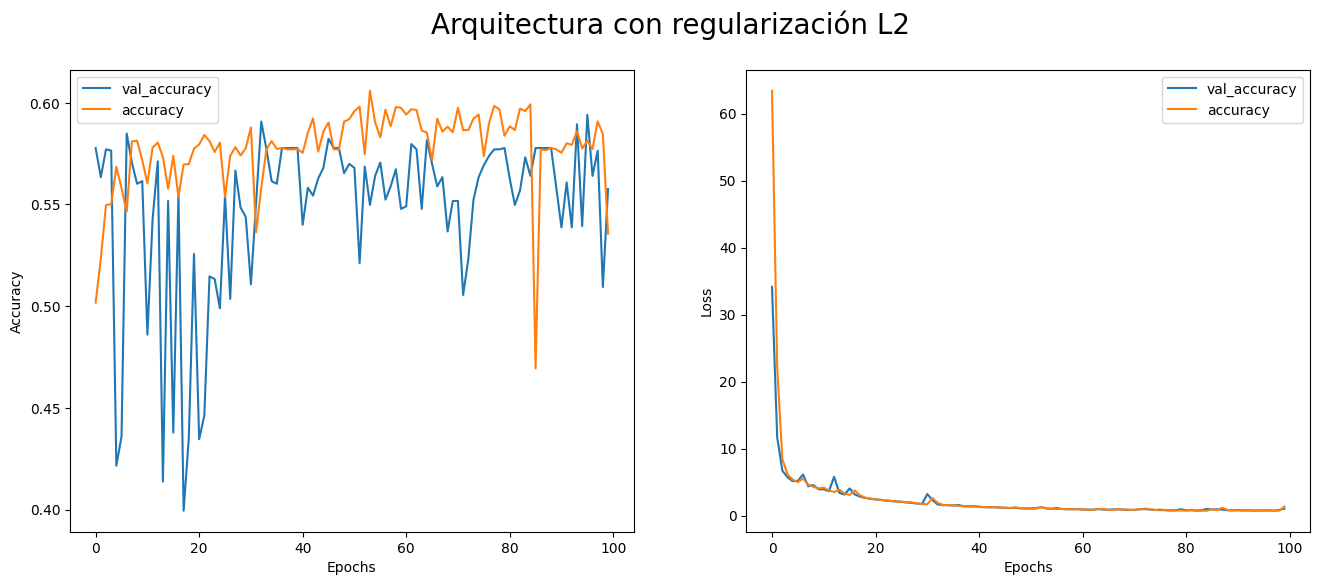

In [70]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='val_accuracy')
plt.plot(history.history['loss'], label='accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("Arquitectura con regularización L2", fontsize=20)
plt.show()

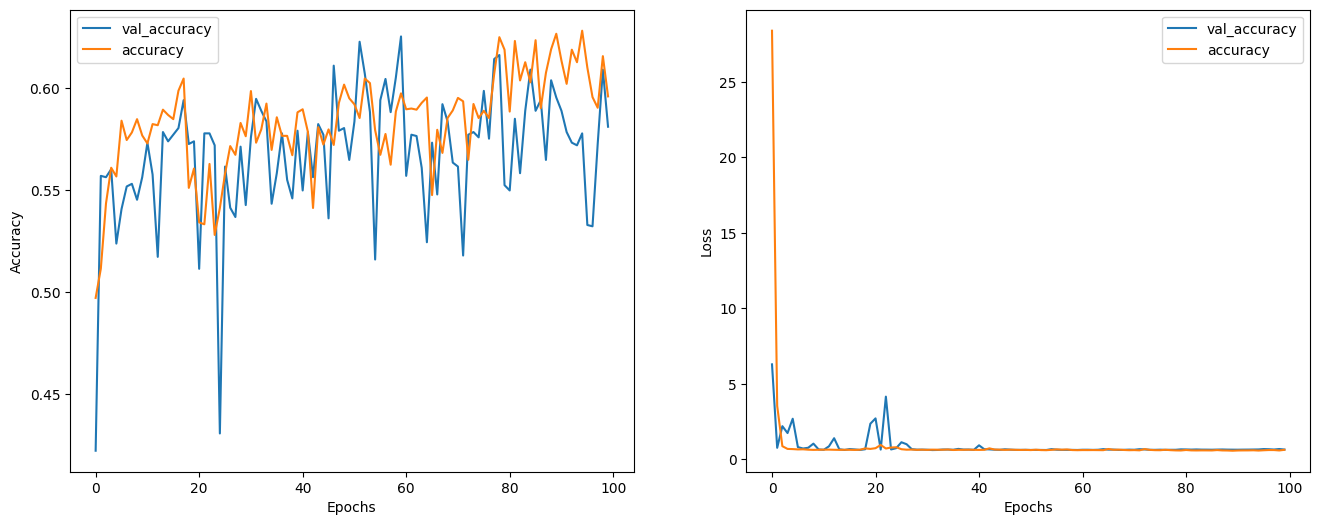

In [43]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='val_accuracy')
plt.plot(history.history['loss'], label='accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("Arquitectura con tasa de aprendizaje de 0.001", fontsize=20)
plt.show()

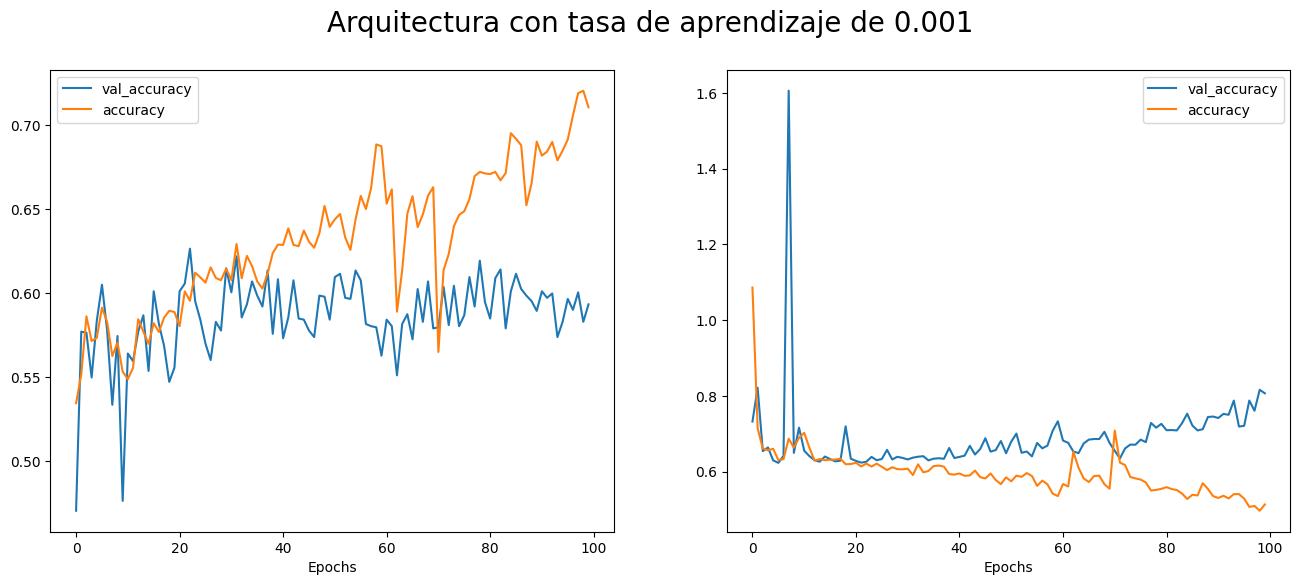

In [59]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='val_accuracy')
plt.plot(history.history['loss'], label='accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.suptitle("Arquitectura con tasa de aprendizaje de 0.001", fontsize=20)
plt.show()

## Autoencoder para realizar la clasificación

In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.layers import Conv1DTranspose, UpSampling1D, Reshape, Conv1D,MaxPooling1D,  Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

### Intento 1

In [101]:
model = Sequential([
    #Encoder
    Conv1D(filters=64, kernel_size=5, activation='leaky_relu',padding="same", input_shape=(75000,1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(filters=128, kernel_size=5, activation='leaky_relu',padding="same"),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(filters=256, kernel_size=5, activation='leaky_relu',padding="same"),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(filters=512, kernel_size=5, activation='leaky_relu',padding="same"),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='leaky_relu'),
    Dropout(0.3),
    Dense(256, activation='leaky_relu'),
    Dropout(0.3),
    Dense(128, activation = 'leaky_relu'),
    Dropout(0.3),
    # Cuello de botella
    Dense(128, activation='relu'),
    #Decoder
    Dense(128, activation='leaky_relu'),
    Dropout(0.3),
    Dense(256, activation='leaky_relu'),
    Dropout(0.3),
    Dense(512, activation='leaky_relu'),
    Dropout(0.3),
    Dense(40960, activation='leaky_relu'), 
    Reshape((80, 256 * 2)),  
    Conv1DTranspose(512, kernel_size=5, activation='leaky_relu', padding='same'),
    UpSampling1D(size=2),
    Dropout(0.5),
    Conv1DTranspose(256, kernel_size=5, activation='leaky_relu', padding='same'),
    UpSampling1D(size=2),
    Dropout(0.5),
    Conv1DTranspose(128, kernel_size=2, activation='leaky_relu'),
    UpSampling1D(size=2),
    Dropout(0.5),
    Conv1DTranspose(64, kernel_size=5, activation='leaky_relu', padding='same'),
    UpSampling1D(size=2),
    Dropout(0.5),
    Conv1DTranspose(1, kernel_size=5, activation='sigmoid', padding='same')
])

In [102]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=['accuracy'])

In [98]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_81 (Conv1D)          (None, 1284, 64)          384       
                                                                 
 max_pooling1d_81 (MaxPooli  (None, 642, 64)           0         
 ng1D)                                                           
                                                                 
 dropout_195 (Dropout)       (None, 642, 64)           0         
                                                                 
 conv1d_82 (Conv1D)          (None, 642, 128)          41088     
                                                                 
 max_pooling1d_82 (MaxPooli  (None, 321, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_196 (Dropout)       (None, 321, 128)        

In [103]:
history = model.fit(X_train, X_train, 
                    epochs=100, 
                    validation_data = (X_val,X_val),
                    batch_size=256,
                    callbacks=[accu_callback])

Epoch 1/100
22/22 [==============================] - 17s 178ms/step - loss: 1.0119 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 2/100
22/22 [==============================] - 3s 147ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 3/100
22/22 [==============================] - 3s 147ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 4/100
22/22 [==============================] - 3s 148ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 5/100
22/22 [==============================] - 3s 147ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 6/100
22/22 [==============================] - 3s 148ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 7/100
22/22 [==============================] - 3s 146ms/step - loss: 1.0000 - accuracy:

KeyboardInterrupt: 

### Intento 2

In [ ]:

input_series = Input(shape=(75000, 1))

#Encoder
encoded = Dense(512, activation='tanh')(input_series)
encoded = Dropout(0.5)(encoded)
encoded = Dense(256, activation='leaky_relu')(encoded)
encoded = Dropout(0.5)(encoded)
encoded = Dense(128, activation='leaky_relu')(encoded)
encoded = Dropout(0.5)(encoded)
#encoded = Dense(16, activation='leaky_relu')(encoded)
#encoded = Dropout(0.5)(encoded)

# Cuello de botella
bottleneck = Dense(1, activation='leaky_relu')(encoded)

#Decoder
#decoded = Dense(16, activation='leaky_relu')(bottleneck)
#decoded = Dropout(0.5)(decoded)
decoded = Dense(128, activation='leaky_relu')(bottleneck)
decoded = Dropout(0.5)(decoded)
decoded = Dense(256, activation='leaky_relu')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(512, activation='tanh')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(1, activation='leaky_relu')(decoded)

# Se carga el autoencoder 
autoencoder = Model(input_series, decoded)
#Optimizador para el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
#Compilacion
autoencoder.compile(optimizer=optimizer,
              loss='mse')

autoencoder.summary()

In [ ]:
#Entrenamiento
history = autoencoder.fit(X_train[y_train==0], X_train[y_train==0], 
                    epochs=20, 
                    validation_data = (X_val,X_val),
                    batch_size=256)

In [ ]:
plt.plot(history.history['loss'],'ro-', label='loss')
plt.plot(history.history['val_loss'],'bo-', label='val_loss')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
##Se extrae solo la info del decoder 
encoder_model = Model(input_series, bottleneck)

##Se realizan las predicciónes
#features_train = encoder_model.predict(X_train)
features_test = encoder_model.predict(X_test)
#features_val = encoder_model.predict(X_val)

In [ ]:
#Comparación entre la curva orginal y la replica
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.title("Curva Orginal")
plt.plot(X_train[3])

plt.subplot(1,2,2)
plt.title("Curva reconstruida")
plt.plot(features_train[3])

#plt.subplot(2,2,3)
#plt.plot(features_train[2])
#plt.plot(X_train[2])

#plt.subplot(2,2,4)
#plt.plot(features_train[3])
#plt.plot(X_train[3])

plt.savefig('Curvas3.png')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

#Se define el error entre las predicciónes
ecm = np.mean(np.power(X_test-features_test,2), axis=1)

#Se fija una metrica para comparar los valores umbral
precision, recall, umbral = precision_recall_curve(y_test, ecm)

plt.plot(umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.savefig("PrecisionRecall")
plt.show()

In [ ]:
#Se define el umbral
umbral_fijo = 1e8
y_pred = [1 if e > umbral_fijo else 0 for e in ecm]

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

In [ ]:
len(y_test)

In [ ]:
classifier_input = Input(shape=(1284,))
classifier_output = Dense(1,activation='sigmoid')(classifier_input)
classifier = Model(classifier_input, classifier_output)

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()

In [ ]:
history_encoder = classifier.fit(features_train,y_train, epochs=50, batch_size=128, validation_data = (features_val,y_val))

In [ ]:
plt.plot(history_encoder.history['accuracy'],'ro-', label='accuracy')
plt.plot(history_encoder.history['val_accuracy'],'bo-', label='val_accuracy')
plt.xlabel('Epochs')
plt.legend()